In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from bs4 import BeautifulSoup
import re

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
# nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
data = pd.read_csv('../data/quora/quora_questions_answers_csv.csv')
data.head()

,question_name,question_url,question_views,question_upvotes,question_shares,question_comments,answer,question_date,question_date_url,question_shares_url
0,What would happen if I walked into a bank to d...,https://www.quora.com/What-would-happen-if-I-w...,80.1K views,917 upvotes,2 shares,38 comments,"To deposit $1 million cash in a bank, first th...",NaN,NaN,NaN
1,Why will most people not become millionaires?,https://www.quora.com/Why-will-most-people-not...,161.5K views,2.2K upvotes,87 shares,24 comments,Because they don’t have the courage to ask for...,NaN,NaN,NaN
2,Is it worth buying a Lamborghini or is there a...,https://www.quora.com/Is-it-worth-buying-a-Lam...,347.9K views,10.3K upvotes,78 shares,116 comments,As someone that owns a Lamborghini I can tell ...,NaN,NaN,NaN
3,What efforts do you do now to become retiring ...,https://www.quora.com/What-efforts-do-you-do-n...,151.5K views,2.6K upvotes,49 shares,100 comments,I am a 69-year-old retired Silicon Valley engi...,NaN,NaN,NaN
4,Do you have to be rich to start a farm?,https://www.quora.com/Do-you-have-to-be-rich-t...,79.2K views,1.3K upvotes,4 shares,72 comments,"Well yes, unless you are willed a farm from a ...",NaN,NaN,NaN


In [4]:
QA = data[['question_name','answer']]

In [10]:
QA.head()

,question_name,answer
0,What would happen if I walked into a bank to d...,"To deposit $1 million cash in a bank, first th..."
1,Why will most people not become millionaires?,Because they don’t have the courage to ask for...
2,Is it worth buying a Lamborghini or is there a...,As someone that owns a Lamborghini I can tell ...
3,What efforts do you do now to become retiring ...,I am a 69-year-old retired Silicon Valley engi...
4,Do you have to be rich to start a farm?,"Well yes, unless you are willed a farm from a ..."


## Exploratory data analysis

#### Number of unique and repeated questions

In [17]:
ques = pd.Series(QA['question_name'].tolist())
print('Number of unique questions',np.unique(ques).shape[0])
x = ques.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 205
Number of questions getting repeated 16


In [25]:
val = ques.value_counts()[:10].values
idx = ques.value_counts()[:10].index

In [36]:
plt.figure(figsize=(10,10))
px.bar(x=val, y=idx, title="Top 10 questions")

<Figure size 1000x1000 with 0 Axes>

### Data Preprocessing and cleaning

In [40]:
def preprocess(data):
    
    data = str(data).lower().strip()
    
    # Replace special characters with their string edatauivalents.
    data = data.replace('%', ' percent')
    data = data.replace('$', ' dollar ')
    data = data.replace('₹', ' rupee ')
    data = data.replace('€', ' euro ')
    data = data.replace('@', ' at ')
    data = data.replace('#', '')
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    data_decontracted = []

    for word in data.split():
        if word in contractions:
            word = contractions[word]

        data_decontracted.append(word)

    data = ' '.join(data_decontracted)
    data = data.replace("'ve", " have")
    data = data.replace("n't", " not")
    data = data.replace("'re", " are")
    data = data.replace("'ll", " will")
    
    # Removing HTML tags
    data = BeautifulSoup(data)
    data = data.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    data = re.sub(pattern, ' ', data).strip()

    
    return data

In [45]:
QA['question_name'] = QA['question_name'].apply(preprocess)
QA['answer'] = QA['answer'].apply(preprocess)

In [46]:
QA.head()

,question_name,answer
0,what would happen if i walked into a bank to d...,to deposit dollar 1 million cash in a bank fir...
1,why will most people not become millionaires,because they don t have the courage to ask for...
2,is it worth buying a lamborghini or is there a...,as someone that owns a lamborghini i can tell ...
3,what efforts do you do now to become retiring ...,i am a 69 year old retired silicon valley engi...
4,do you have to be rich to start a farm,well yes unless you are willed a farm from a r...


## Adding New Features
1. question_length
2. question_num_words
6. total words

In [54]:
QA['question_length'] = QA['question_name'].apply(lambda row: len(row))
QA['question_num_words'] = QA['question_name'].apply(lambda row: len(row.split(" ")))
QA['ans_length'] = QA['answer'].apply(lambda row: len(row))
QA['ans_num_words'] = QA['answer'].apply(lambda row: len(row.split(" ")))

In [55]:
QA.head()

,question_name,answer,question_length,question_num_words,ans_length,ans_num_words
0,what would happen if i walked into a bank to d...,to deposit dollar 1 million cash in a bank fir...,134,26,1103,218
1,why will most people not become millionaires,because they don t have the courage to ask for...,44,7,965,180
2,is it worth buying a lamborghini or is there a...,as someone that owns a lamborghini i can tell ...,78,15,1526,300
3,what efforts do you do now to become retiring ...,i am a 69 year old retired silicon valley engi...,53,10,1270,240
4,do you have to be rich to start a farm,well yes unless you are willed a farm from a r...,38,10,731,148


#### Analysis of features

minimum characters 21
maximum characters 258
average num of characters 85


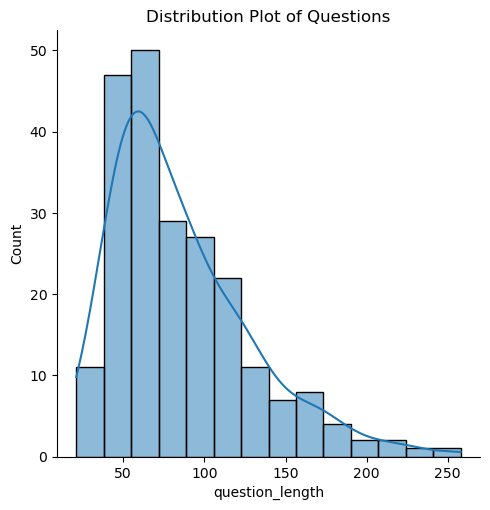

In [61]:
sns.displot(QA['question_length'], kde=True)
plt.title('Distribution Plot of Questions')
print('minimum characters',QA['question_length'].min())
print('maximum characters',QA['question_length'].max())
print('average num of characters',int(QA['question_length'].mean()))

#### Most of the users asks questions length of between 50-150  

minimum characters 3
maximum characters 10313
average num of characters 749


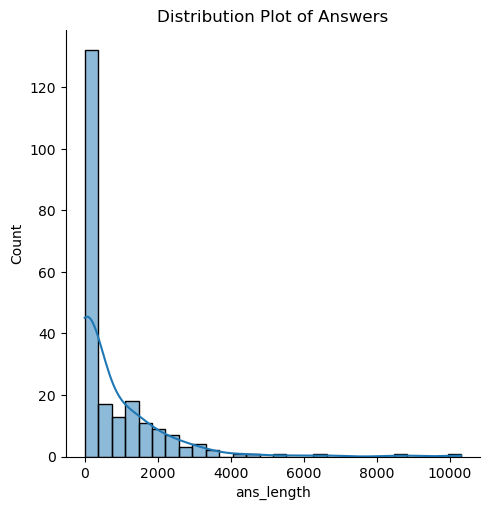

In [62]:
sns.displot(QA['ans_length'], kde=True)
plt.title('Distribution Plot of Answers')
print('minimum characters',QA['ans_length'].min())
print('maximum characters',QA['ans_length'].max())
print('average num of characters',int(QA['ans_length'].mean()))

### Word Cloud

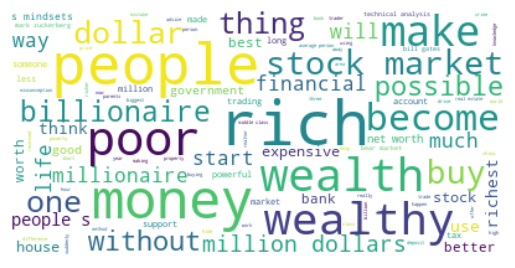

In [67]:
from wordcloud import WordCloud

ques_text = QA['question_name'].str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(ques_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

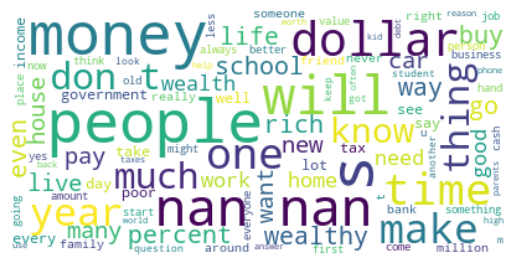

In [68]:
ans_text = QA['answer'].str.cat(sep=' ')
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(ans_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### get n-grams

In [119]:
def get_ngrams(text, n_grams=1):
    ngrams_text = []
    ngrams_txt = ngrams(text.split(), n_grams)
    ngrams_text.extend(ngrams_txt)
    return ngrams_text

In [122]:
ques_ngram = QA['question_name'].apply(lambda x : get_ngrams(x,2)).tolist()

In [125]:
ques_ngram[:2]

[[('what', 'would'),
  ('would', 'happen'),
  ('happen', 'if'),
  ('if', 'i'),
  ('i', 'walked'),
  ('walked', 'into'),
  ('into', 'a'),
  ('a', 'bank'),
  ('bank', 'to'),
  ('to', 'deposit'),
  ('deposit', 'dollar'),
  ('dollar', '1'),
  ('1', 'million'),
  ('million', 'dollars'),
  ('dollars', 'in'),
  ('in', 'cash'),
  ('cash', 'do'),
  ('do', 'most'),
  ('most', 'banks'),
  ('banks', 'have'),
  ('have', 'machines'),
  ('machines', 'that'),
  ('that', 'do'),
  ('do', 'the'),
  ('the', 'counting')],
 [('why', 'will'),
  ('will', 'most'),
  ('most', 'people'),
  ('people', 'not'),
  ('not', 'become'),
  ('become', 'millionaires')]]